### Advanced Machine Learning Technologies. Autumn 2022.
### TASK 1. Sorokin Mikhail group J42322c.

### ARIMA model forecast

In [2]:
# let's import necassary packages...

%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\sorok\AppData\Local\Temp\ipykernel_12700\63396338.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
WAG = pd.read_csv('Tempreture_1901_2016_Pakistan.csv')
WAG

,Temperature - (Celsius),Year,Month
0,7.72768,1901,January
1,8.93600,1901,February
2,16.96320,1901,March
3,21.27410,1901,April
4,26.04970,1901,May
...,...,...,...
1387,27.63320,2016,August
1388,26.71790,2016,September
1389,22.39820,2016,October
1390,15.76720,2016,November


In [4]:
mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7,
            'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}
WAG = WAG.replace({'Month': mapping})
WAG

,Temperature - (Celsius),Year,Month
0,7.72768,1901,1
1,8.93600,1901,2
2,16.96320,1901,3
3,21.27410,1901,4
4,26.04970,1901,5
...,...,...,...
1387,27.63320,2016,8
1388,26.71790,2016,9
1389,22.39820,2016,10
1390,15.76720,2016,11


In [5]:
WAG.columns.values.tolist()

['Temperature - (Celsius)', ' Year', 'Month']

In [6]:
WAG['Date'] = WAG['Month'].astype(str) + ".1." + WAG[' Year'].astype(str)
WAG

,Temperature - (Celsius),Year,Month,Date
0,7.72768,1901,1,1.1.1901
1,8.93600,1901,2,2.1.1901
2,16.96320,1901,3,3.1.1901
3,21.27410,1901,4,4.1.1901
4,26.04970,1901,5,5.1.1901
...,...,...,...,...
1387,27.63320,2016,8,8.1.2016
1388,26.71790,2016,9,9.1.2016
1389,22.39820,2016,10,10.1.2016
1390,15.76720,2016,11,11.1.2016


In [7]:
WAG['Date'].astype('datetime64[ns]')

0      1901-01-01
1      1901-02-01
2      1901-03-01
3      1901-04-01
4      1901-05-01
          ...    
1387   2016-08-01
1388   2016-09-01
1389   2016-10-01
1390   2016-11-01
1391   2016-12-01
Name: Date, Length: 1392, dtype: datetime64[ns]

In [8]:
WAG['Date'] = pd.to_datetime(WAG.Date)
WAG = WAG.set_index('Date')
WAG = WAG[['Temperature - (Celsius)']].tail(240)
WAG.rename(columns = {'Temperature - (Celsius)':'Temperature'}, inplace = True)
data = WAG
WAG

,Temperature
Date,
1997-01-01,8.51052
1997-02-01,11.07330
1997-03-01,15.51460
1997-04-01,19.93410
1997-05-01,24.00340
...,...
2016-08-01,27.63320
2016-09-01,26.71790
2016-10-01,22.39820


<Figure size 864x432 with 0 Axes>

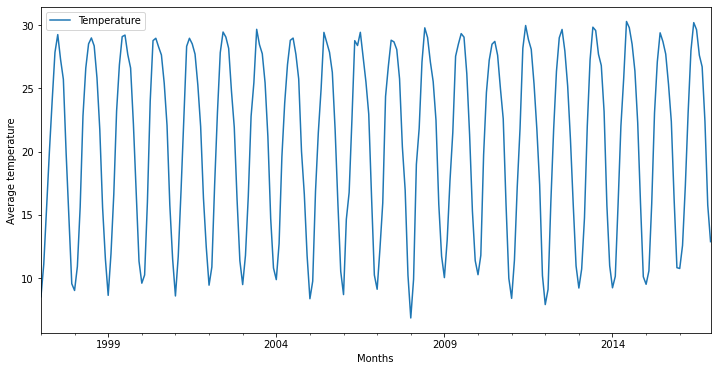

In [9]:
plt.figure(figsize(12,6))
WAG.plot()
plt.ylabel('Average temperature')
plt.xlabel('Months')
pylab.show()

Dickey-Fuller test: p=0.004148


<Figure size 1080x720 with 0 Axes>

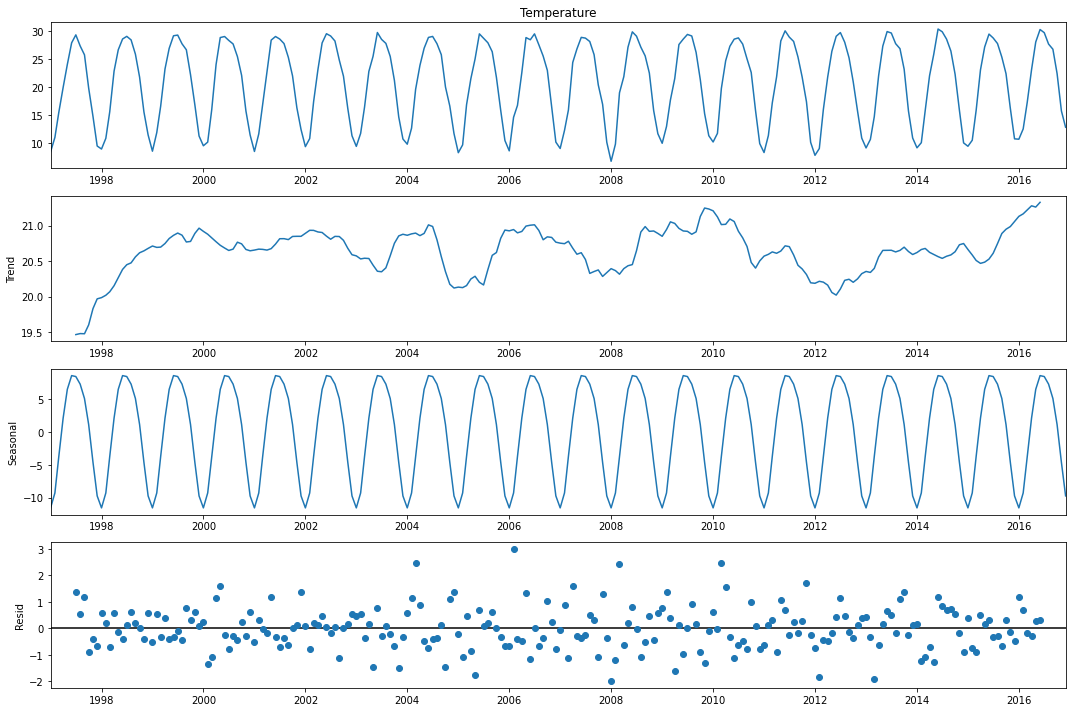

In [10]:
# evaluate components of time-series
# evaluate Dickey-Fuller test for time-series stationarity

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.Temperature).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.Temperature)[1])

Best Box-Cox parameter: 1.210478
Dickey-Fuller test: p=0.003212


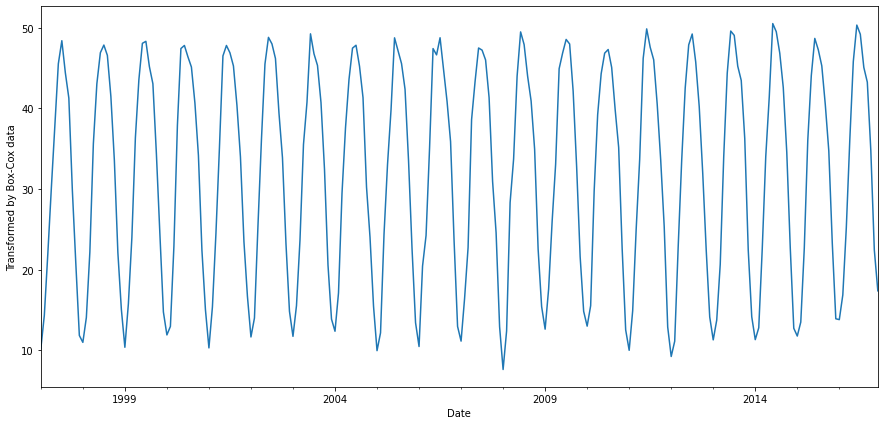

In [11]:
# Box-Cox transformation for dispersion stationarity

WAG['WAG_C_M_box'], lmbda = stats.boxcox(WAG.Temperature)
plt.figure(figsize(15,7))
WAG.WAG_C_M_box.plot()
plt.ylabel('Transformed by Box-Cox data')
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box)[1])

Dickey-Fuller test: p=0.000018


<Figure size 1080x720 with 0 Axes>

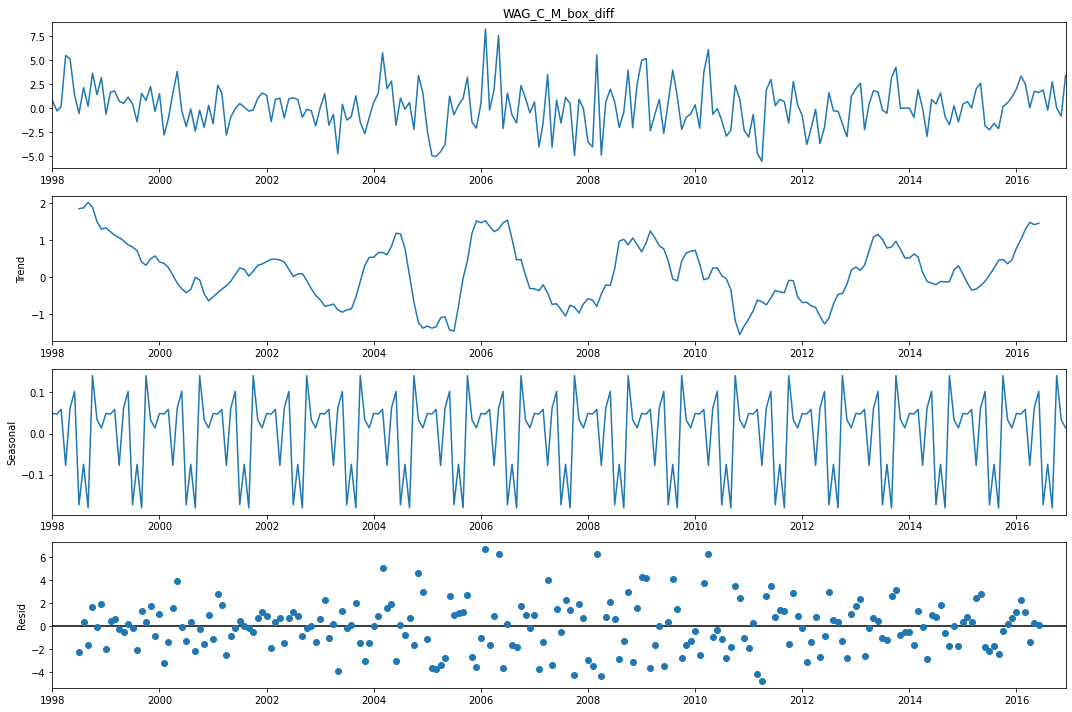

In [12]:
# seasonal difference for 12 months

WAG['WAG_C_M_box_diff'] = WAG.WAG_C_M_box - WAG.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff[12:]).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff[12:])[1])

Dickey-Fuller test: p=0.000000228910721


<Figure size 1080x720 with 0 Axes>

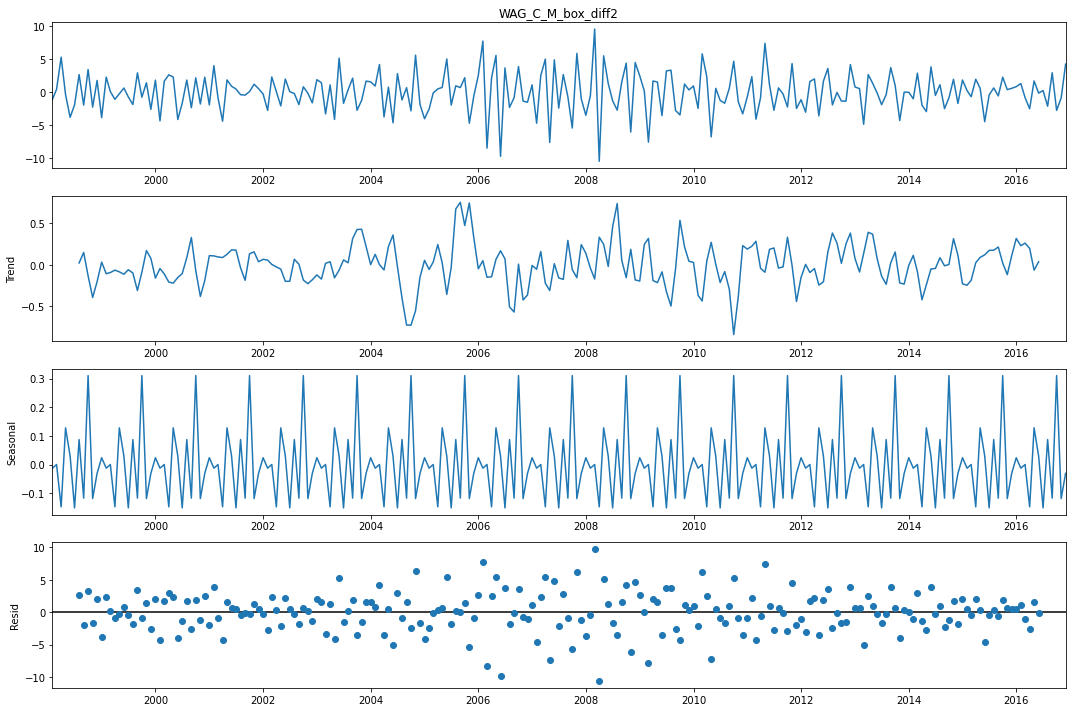

In [13]:
# additional 1-step difference

WAG['WAG_C_M_box_diff2'] = WAG.WAG_C_M_box_diff - WAG.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.WAG_C_M_box_diff2[13:]).plot()
print("Dickey-Fuller test: p=%.15f" % sm.tsa.stattools.adfuller(WAG.WAG_C_M_box_diff2[13:])[1])

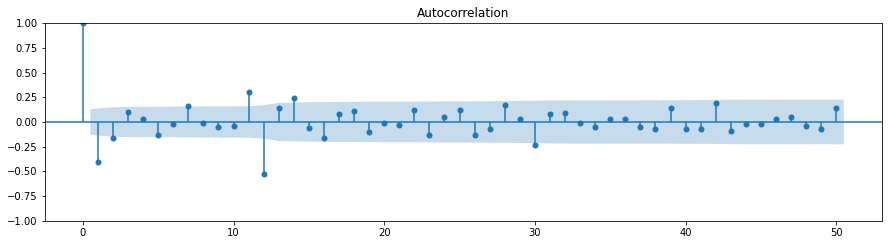

c:\Users\sorok\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


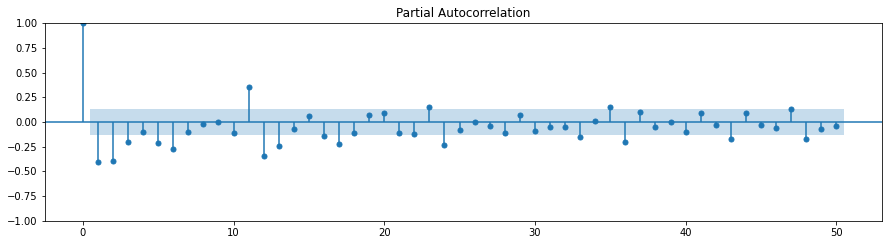

In [14]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.WAG_C_M_box_diff2[13:].values.squeeze(), lags=50, ax=ax)
pylab.show()

In [15]:
# parameters for SARIMA model
# better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise

ps = range(0, 6)   # 5 
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [16]:
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters         aic
9  (3, 3, 1, 0)  959.533153
8  (2, 4, 1, 0)  960.621150
7  (2, 2, 1, 0)  965.609040
6  (1, 3, 1, 0)  965.726168
5  (1, 2, 1, 0)  965.958897


In [17]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters         aic
9  (3, 3, 1, 0)  959.533153
8  (2, 4, 1, 0)  960.621150
7  (2, 2, 1, 0)  965.609040
6  (1, 3, 1, 0)  965.726168
5  (1, 2, 1, 0)  965.958897


In [18]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         WAG_C_M_box   No. Observations:                  240
Model:             SARIMAX(3, 1, 3)x(1, 1, [], 12)   Log Likelihood                -471.767
Date:                             Sat, 15 Oct 2022   AIC                            959.533
Time:                                     22:58:43   BIC                            986.933
Sample:                                 01-01-1997   HQIC                           970.589
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0144      0.063     -0.230      0.818      -0.137       0.109
ar.L2         -0.8570      

Student test: p=0.111832
Dickey-Fuller test: p=0.0000000000000000000000000


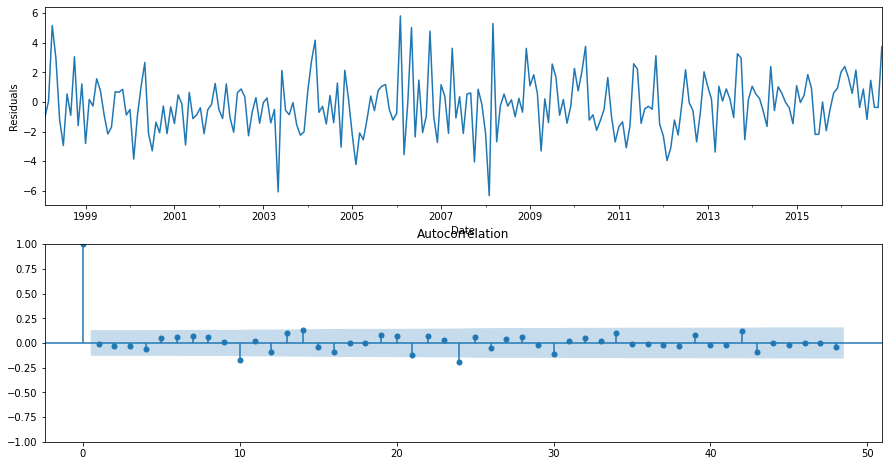

In [19]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

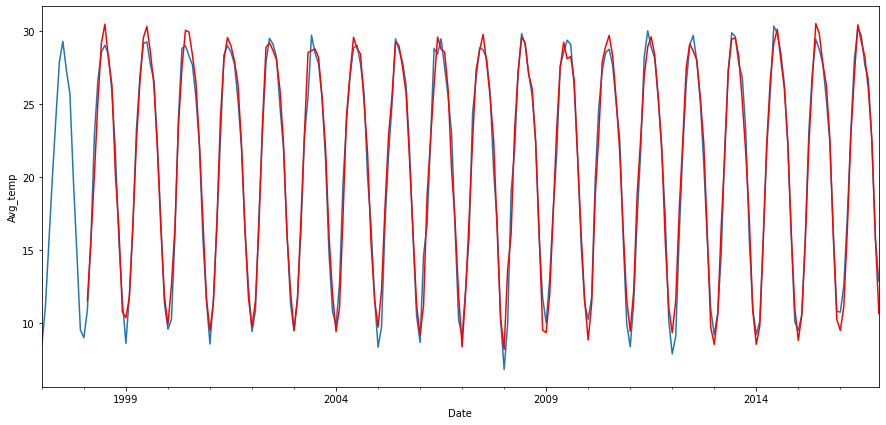

In [20]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
WAG['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.Temperature.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Avg_temp')
pylab.show()

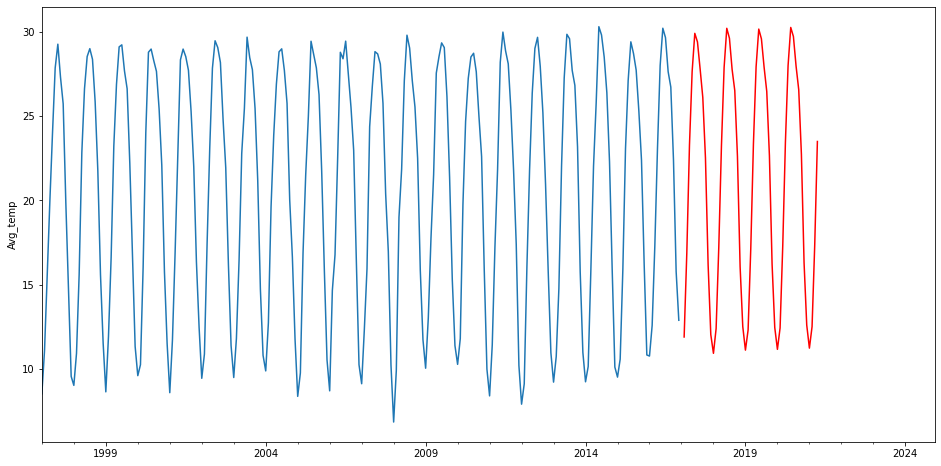

In [21]:
WAG2 = WAG[['Temperature']]
date_list = [datetime.strptime("2017-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,96)]
future = pd.DataFrame(index=date_list, columns= WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(best_model.predict(start=241, end=291), lmbda)

plt.figure(figsize(16,8))
WAG2.Temperature.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Avg_temp')
pylab.show()

### LSTM model forecast

In [22]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    
    # stateful = True - keep state in memory;
    
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.1,epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
 
# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted

In [23]:
data = data[['Temperature']]
data

,Temperature
Date,
1997-01-01,8.51052
1997-02-01,11.07330
1997-03-01,15.51460
1997-04-01,19.93410
1997-05-01,24.00340
...,...
2016-08-01,27.63320
2016-09-01,26.71790
2016-10-01,22.39820


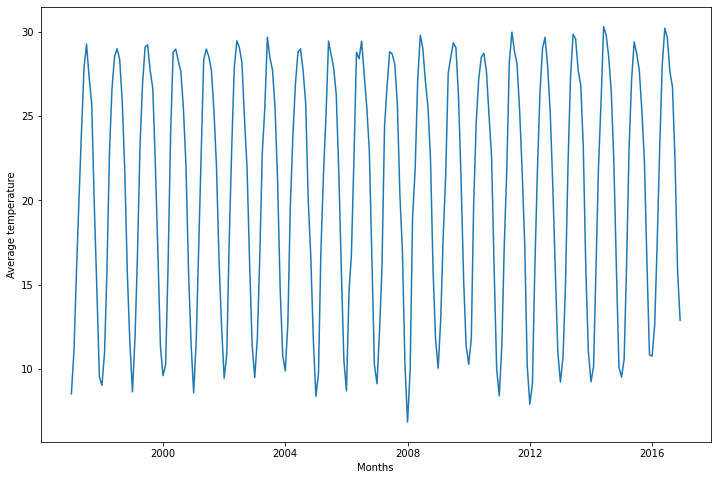

In [24]:
# Data

plt.figure(figsize=(12,8))
plt.plot(data)
plt.ylabel('Average temperature')
plt.xlabel('Months')
plt.show()

In [25]:
# trajectory matrix

d1 = series_to_supervised(data, n_in=5, n_out=7, dropnan=True)
d1

,var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4),var1(t+5),var1(t+6)
Date,,,,,,,,,,,,
1997-06-01,8.51052,11.0733,15.5146,19.9341,24.0034,27.8558,29.2669,27.30210,25.72550,19.82130,14.78350,9.54585
1997-07-01,11.07330,15.5146,19.9341,24.0034,27.8558,29.2669,27.3021,25.72550,19.82130,14.78350,9.54585,9.01244
1997-08-01,15.51460,19.9341,24.0034,27.8558,29.2669,27.3021,25.7255,19.82130,14.78350,9.54585,9.01244,10.91070
1997-09-01,19.93410,24.0034,27.8558,29.2669,27.3021,25.7255,19.8213,14.78350,9.54585,9.01244,10.91070,15.62020
1997-10-01,24.00340,27.8558,29.2669,27.3021,25.7255,19.8213,14.7835,9.54585,9.01244,10.91070,15.62020,22.82890
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-02-01,25.31790,22.3790,16.2182,10.8177,10.7526,12.5766,17.2900,23.09200,27.99960,30.21440,29.65740,27.63320
2016-03-01,22.37900,16.2182,10.8177,10.7526,12.5766,17.2900,23.0920,27.99960,30.21440,29.65740,27.63320,26.71790
2016-04-01,16.21820,10.8177,10.7526,12.5766,17.2900,23.0920,27.9996,30.21440,29.65740,27.63320,26.71790,22.39820


In [26]:
# hyperparameters initialization and training the model

n_lag = 36
n_seq = 48
n_test = 1
n_epochs = 30
n_batch = 1
n_neurons =  8

scaler, train, test = prepare_data(data, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(data, forecasts, scaler, n_test+2)


0
139/139 [==============================] - 1s 3ms/step - loss: 0.2148 - val_loss: 0.1637
1
139/139 [==============================] - 0s 1ms/step - loss: 0.1132 - val_loss: 0.0633
2
139/139 [==============================] - 0s 1ms/step - loss: 0.0558 - val_loss: 0.0324
3
139/139 [==============================] - 0s 1ms/step - loss: 0.0426 - val_loss: 0.0262
4
139/139 [==============================] - 0s 1ms/step - loss: 0.0390 - val_loss: 0.0237
5
139/139 [==============================] - 0s 1ms/step - loss: 0.0366 - val_loss: 0.0217
6
139/139 [==============================] - 0s 1ms/step - loss: 0.0343 - val_loss: 0.0197
7
139/139 [==============================] - 0s 1ms/step - loss: 0.0320 - val_loss: 0.0179
8
139/139 [==============================] - 0s 1ms/step - loss: 0.0299 - val_loss: 0.0163
9
139/139 [==============================] - 0s 1ms/step - loss: 0.0281 - val_loss: 0.0151
10
139/139 [==============================] - 0s 1ms/step - loss: 0.0266 - val_loss: 0.014

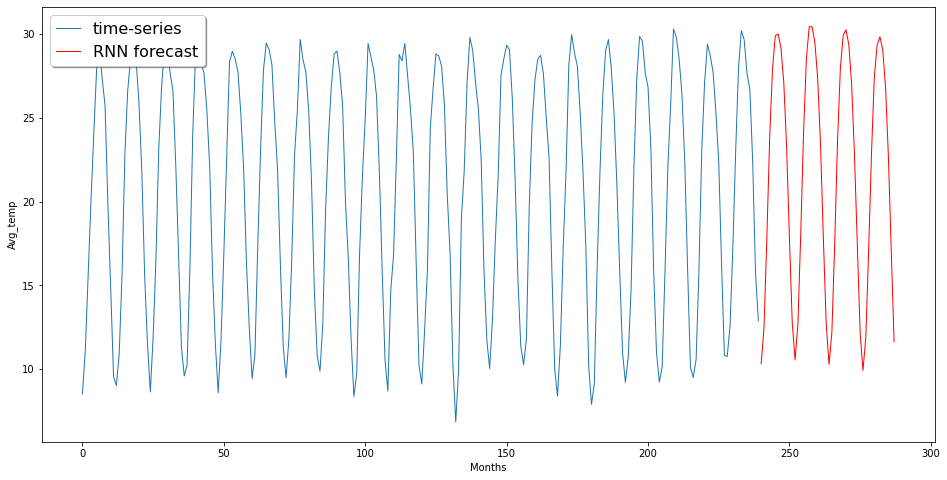

In [33]:
# visualize

fig=plt.figure(figsize=(16,8))
plt.plot(data.values[:],linewidth=1)
off_s = len(data) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
yaxis = [x-14 for x in yaxis[1:]]
plt.plot(xaxis[1:], yaxis, color='r',linewidth=1)

plt.ylabel('Avg_temp')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()

[0.022519145160913467] [0.012833645567297935]


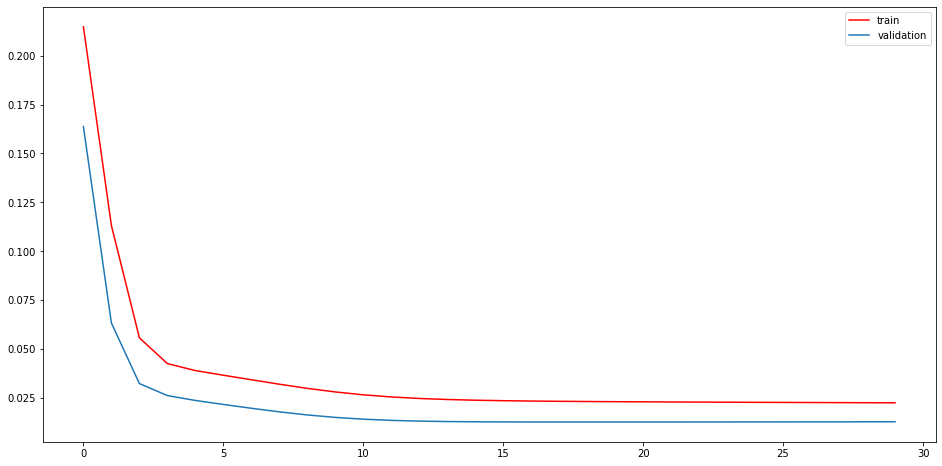

In [34]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

### Results

In [35]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error

y_true = WAG.Temperature.tolist()[190:241]
y_pred_arima = WAG.model.tolist()[190:241]

# ARIMA R2 and MAPE:
print('ARIMA:')
print('r2_score: ',r2_score(y_true, y_pred_arima))
print('MAPE: ',mean_absolute_percentage_error(y_true, y_pred_arima))
# LSTM R2 and MAPE:
print('\nLSTM:')
print('r2_score: ',r2_score(yaxis[1:], WAG2.forecast.tolist()[241:288]))
print('MAPE: ',mean_absolute_percentage_error(yaxis[1:], WAG2.forecast.tolist()[241:288]))

ARIMA:
r2_score:  0.9872054402356993
MAPE:  0.038412638151242226

LSTM:
r2_score:  0.9869007803071832
MAPE:  0.03434335672121699


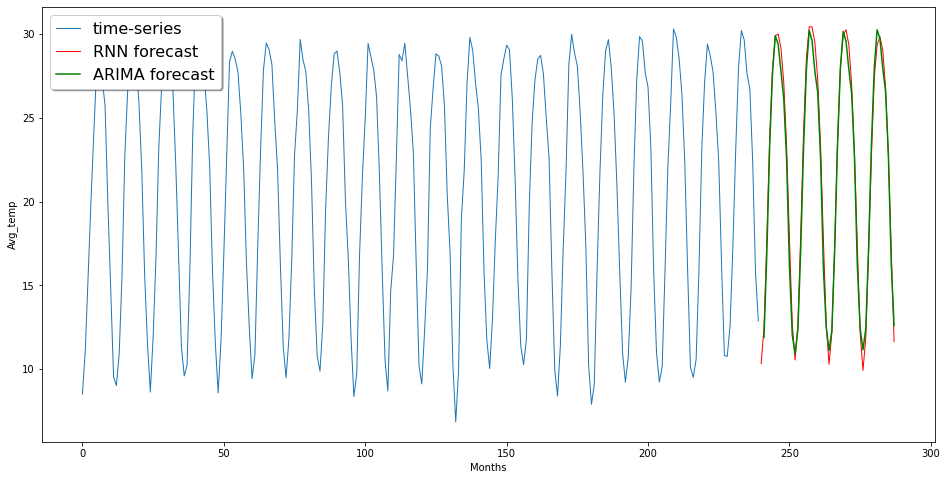

In [37]:
# visualize

fig=plt.figure(figsize=(16,8))
plt.plot(data.values[:],linewidth=1)
off_s = len(data) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [data.values[off_s]] + forecasts[-1]
yaxis = [x-14 for x in yaxis[1:]]
plt.plot(xaxis[1:], yaxis, color='r',linewidth=1)
plt.plot(xaxis[2:], WAG2.forecast.tolist()[241:288], color='g')
plt.ylabel('Avg_temp')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast', 'ARIMA forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()


In [38]:
# Both models are very good and have similiar results. The result differ from time to time and overall I prefer LSTM slightly more often.